In [1]:
import pandas as pd

log_df = pd.read_csv("access_log.csv", parse_dates=["date"])
print(len(log_df))
log_df.head()

325908


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04


In [2]:
log_df["user_id"].value_counts().describe()

count    31443.000000
mean        10.365042
std         16.023399
min          2.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        632.000000
Name: count, dtype: float64

In [3]:
log_df["item_id"].value_counts().describe()

count    87611.000000
mean         3.719944
std          8.802572
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        941.000000
Name: count, dtype: float64

In [4]:
log_df["date"].value_counts()

date
2015-07-03    45441
2015-07-02    45394
2015-07-01    44163
2015-07-04    43804
2015-07-08    39933
2015-07-05    39932
2015-07-07    33930
2015-07-06    33311
Name: count, dtype: int64

In [5]:
import datetime

start_date = datetime.datetime(2015, 7, 1)
end_date = datetime.datetime(2015, 7, 7)
target_date = datetime.datetime(2015, 7, 8)

In [6]:
x_df = log_df[(start_date <= log_df["date"]) & (log_df["date"] <= end_date)]
print(len(x_df))
x_df.head(3)

285975


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04


In [7]:
y_df = log_df[log_df["date"] == target_date]
print(len(y_df))
y_df.head()

39933


,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08


In [8]:
U2I2Rcens = {}
for row in x_df.itertuples():
    rcen = (target_date - row.date).days

    U2I2Rcens.setdefault(row.user_id, {})
    U2I2Rcens[row.user_id].setdefault(row.item_id, [])
    U2I2Rcens[row.user_id][row.item_id].append(rcen)

In [9]:
U2I2Rcens[2497]

{400521: [4, 2, 2, 2, 1], 678277: [4], 687963: [2], 178138: [1]}

In [10]:
Rows1 = []
for user_id, I2Rcens in U2I2Rcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rows1.append((user_id, item_id, rcen, freq))
UI2RF_df = pd.DataFrame(Rows1, columns=["user_id", "item_id", "rcen", "freq"])
print(len(UI2RF_df))
UI2RF_df.head()

204661


,user_id,item_id,rcen,freq
0,4,205587,4,1
1,4,748683,4,1
2,4,790055,4,3
3,4,764638,4,2
4,4,492434,4,1


In [11]:
y_df = y_df.drop_duplicates()
print(len(y_df))
y_df["pv_flag"] = 1
y_df.head()

29651


,user_id,item_id,date,pv_flag
103,94,603852,2015-07-08,1
104,94,28600,2015-07-08,1
105,94,987320,2015-07-08,1
106,94,109924,2015-07-08,1
107,94,886214,2015-07-08,1


In [12]:
UI2RFP_df = pd.merge(
    UI2RF_df,
    y_df[["user_id", "item_id", "pv_flag"]],
    how="left",
    on=["user_id", "item_id"],
)
UI2RFP_df["pv_flag"].fillna(0, inplace=True)
print(len(UI2RFP_df))
UI2RFP_df.head()

204661


C:\Users\sn3ak\AppData\Local\Temp\ipykernel_30096\527437461.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  UI2RFP_df["pv_flag"].fillna(0, inplace=True)


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [13]:
print(sorted(UI2RFP_df["rcen"].unique()))
print(sorted(UI2RFP_df["freq"].unique()))

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 41, 43, 58, 63, 118]


In [14]:
tar_df = UI2RFP_df[UI2RFP_df["freq"] <= 7]
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [15]:
print(tar_df["pv_flag"].sum())

2038.0


In [16]:
rcen_df = pd.crosstab(index=tar_df["rcen"], columns=tar_df["pv_flag"])
rcen_df = rcen_df.rename(columns={0: "neg", 1: "pos"})
rcen_df

pv_flag,neg,pos
rcen,,
1,24595,571
2,24032,274
3,28212,326
4,30641,275
5,31510,225
6,31721,199
7,30707,168


In [17]:
rcen_df = pd.crosstab(index=tar_df["rcen"], columns=tar_df["pv_flag"])
rcen_df = rcen_df.rename(columns={0: "neg", 1: "pos"})
rcen_df

pv_flag,neg,pos
rcen,,
1,24595,571
2,24032,274
3,28212,326
4,30641,275
5,31510,225
6,31721,199
7,30707,168


pv_flag,neg,pos,N,prob
rcen,,,,
1,24595,571,25166,0.022689
2,24032,274,24306,0.011273
3,28212,326,28538,0.011423
4,30641,275,30916,0.008895
5,31510,225,31735,0.007090
6,31721,199,31920,0.006234
7,30707,168,30875,0.005441


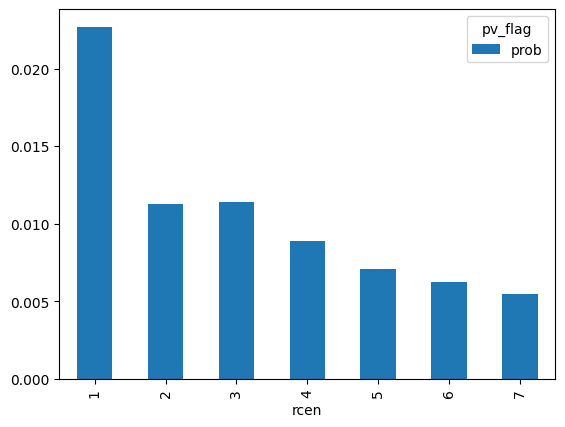

In [18]:
rcen_df["N"] = rcen_df["neg"] + rcen_df["pos"]
rcen_df["prob"] = rcen_df["pos"] / rcen_df["N"]
rcen_df[["prob"]].plot.bar()
rcen_df

In [19]:
freq_df = pd.crosstab(index=tar_df["freq"], columns=tar_df["pv_flag"])
freq_df = freq_df.rename(columns={0: "neg", 1: "pos"})
freq_df

pv_flag,neg,pos
freq,,
1,161753,964
2,24938,476
3,7733,258
4,3527,149
5,1807,88
6,1038,63
7,622,40


pv_flag,neg,pos,N,prob
freq,,,,
1,161753,964,162717,0.005924
2,24938,476,25414,0.018730
3,7733,258,7991,0.032286
4,3527,149,3676,0.040533
5,1807,88,1895,0.046438
6,1038,63,1101,0.057221
7,622,40,662,0.060423


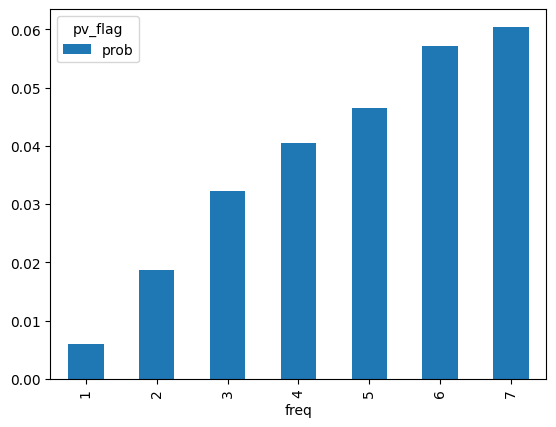

In [20]:
freq_df["N"] = freq_df["neg"] + freq_df["pos"]
freq_df["prob"] = freq_df["pos"] / freq_df["N"]
freq_df[["prob"]].plot.bar()
freq_df

In [21]:
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [22]:
RF2N = {}
RF2PV = {}
for row in tar_df.itertuples():
    RF2N.setdefault((row.rcen, row.freq), 0)
    RF2PV.setdefault((row.rcen, row.freq), 0)
    RF2N[row.rcen, row.freq] += 1
    if row.pv_flag == 1:
        RF2PV[row.rcen, row.freq] += 1

In [23]:
RF2Prob = {}
for rf, N in RF2N.items():
    RF2Prob[rf] = RF2PV[rf] / N

In [24]:
Rows3 = []
for rf, N in sorted(RF2N.items()):
    pv = RF2PV[rf]
    prob = RF2Prob[rf]
    row = (rf[0], rf[1], N, pv, prob)
    Rows3.append(row)
rf_df = pd.DataFrame(Rows3, columns=["rcen", "freq", "N", "pv", "prob"])
print(len(rf_df))
rf_df.head()

49


,rcen,freq,N,pv,prob
0,1,1,19602,245,0.012499
1,1,2,3323,132,0.039723
2,1,3,1120,81,0.072321
3,1,4,539,36,0.066790
4,1,5,285,36,0.126316


In [25]:
rf_df.pivot_table(index="rcen", columns="freq", values="prob")

freq,1,2,3,4,5,6,7
rcen,,,,,,,
1,0.012499,0.039723,0.072321,0.066790,0.126316,0.112994,0.175000
2,0.005856,0.021189,0.026973,0.056645,0.066225,0.098765,0.063830
3,0.006107,0.023230,0.039621,0.053265,0.039427,0.054054,0.050420
4,0.005454,0.015366,0.024521,0.046901,0.036667,0.037838,0.018349
5,0.004376,0.015504,0.023673,0.014925,0.021898,0.028902,0.030612
6,0.004456,0.009848,0.024514,0.019569,0.008511,0.024793,0.025316
7,0.004256,0.009086,0.014056,0.023377,0.009091,0.020408,0.000000


In [26]:
import numpy as np
import matplotlib.pyplot as plt

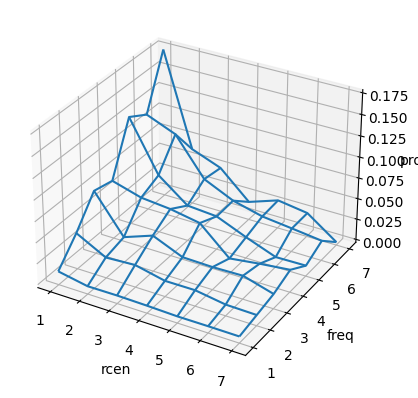

In [27]:
Freq = rf_df["freq"].unique().tolist()
Rcen = rf_df["rcen"].unique().tolist()
Z = [
    rf_df[(rf_df["freq"] == freq) & (rf_df["rcen"] == rcen)]["prob"].iloc[0]
    for freq in Freq
    for rcen in Rcen
]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", xlabel="rcen", ylabel="freq", zlabel="prob")
ax.plot_wireframe(X, Y, Z)

In [ ]:
G_list = [
    [-1, 0, 0],
    [1, 0, 0],
    [0, -1, 0],
    [0, 1, 0],
    [0, 0, -1],
    [0, 0, 1],
    [1, -1, 0],
    [0, 1, -1],
    [1, -2, 1],
]

h_list = [0, 1, 0, 1, 0, 1, 0, 0, 0]

P_list = [[2 * 100, 0, 0], [0, 2 * 50, 0], [0, 0, 2 * 10]]

q_list = [-2 * 100 * 0.1, -2 * 50 * 0.15, -2 * 10 * 0.25]